### Import the required libraries

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
import torch, torchtext
from torchtext import data
import torch.optim as optim

import os, pickle

import torch.nn as nn
import torch.nn.functional as F
import json

### Get pre processed Stanford sentiment analysis dataset

Pre processing of data is done separately to better manage the time between data augmentation and testing the LSTM model.This notebook is focussed on model tuning and performance.More details about data augmentation is provided in the other notebook.A high level view of the augmentation strategy is provided here to give a context about the data. 

Original datasset has 11286 sentences with labels , data is augmented to generate 45144 additional sentences with labels.

The following augmentation strategy is used to mimic real life data

1.   random swap - The words are randomly swapped to mimic users comment on a movie
2.   random deletion - words are randomly deleted but the labels are kept same.This mimics user feedback when they put their review in a hurry.
3.   random insertion - stopwords are removed and some words are repeated to stress importance or convey users feeling about the movie.
4.   use google  translate to translate the review comment to a random destination language and re translate to english.This mimics users review comment from different parts of the world into one standard language.

#### The labels are normalized into 5 categories based on the following rule

1.   *0 <= If the rating is  <= 0.2 - label is 0* which is mapped to **Very negative**
2.   *0.2 < If the rating is  <= 0.4 - label is 1* which is mapped to **negative**

3.   *0.4 < If the rating is  <= 0.6 - label is 2* which is mapped to **neutral**

4.   *0.6 < If the rating is  <= 0.8 - label is 3* which is mapped to **positive**

5.   *0.8 < If the rating is  <= 1.0 - label is 4* which is mapped to **Very positive**





In [6]:


df = pd.read_csv("/content/orig_swap_del_tlt_insDF.csv") #   "/content/tweets.csv")
df.tail()

,sentence,label
56425,real snooze .,0
56426,surprise .,1
56427,' ve see see see see_to_it see_to_it see_to_i...,3
56428,rooter rooter rooter walk walk walk walk wal...,0
56429,instance instance instance example example ex...,1


In [7]:
df.shape

(56430, 2)

### A quick glance of the label statistics

Majority of the comments have a label of **negative or positive or neutral**  , users avoid giving outlier labels like **Very negative or Very positive**.

In [8]:
df.label.value_counts()

1    14855
3    14830
2    10720
4     8865
0     7160
Name: label, dtype: int64

In [9]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

### Create Field and LabelField variables to hold the comment and label information

**Field** - Defines a datatype together with instructions for converting to Tensor.

Field class models common text processing datatypes that can be represented by tensors. It holds a Vocab object that defines the set of possible values for elements of the field and their corresponding numerical representations. The Field object also holds other parameters relating to how a datatype should be numericalized, such as a tokenization method and the kind of Tensor that should be produced.

1.   The comment will be stored in **Sentence** Field object
2.   The label will be stored in **Label** LabelField object


In [10]:
Sentence = torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

#### Map the 2 variables to column header 

| Column header | Variable name |
| --- | --- |
| **sentence** | Sentence |
| **label** | Label |

In [11]:
fields = [('sentence', Sentence), ('label', Label)]

### Create a list of example

by doing list comprehension of the sentence and label dataframe generated from the preprocessed csv file

In [12]:
example = [torchtext.legacy.data.Example.fromlist([df.sentence[i],df.label[i]], fields) for i in range(df.shape[0])] 

### Create the Dataset 

by providing the above list of examples and the field mapping

In [13]:
stanfordDataset = torchtext.legacy.data.Dataset(example, fields)

In [14]:
stanfordDataset

### Split the dataset into

train and validation in the ratio of **85:15**

In [15]:
(train, valid) = stanfordDataset.split(split_ratio=[85, 15], random_state = random.seed(SEED))

In [16]:
len(train), len(valid)

(47966, 8464)

In [17]:
train.fields

{'label': <torchtext.legacy.data.field.LabelField at 0x7f8915d3f950>,
 'sentence': <torchtext.legacy.data.field.Field at 0x7f896b5f2d10>}

#### a quick glance of a train record

In [18]:
vars(train.examples[15])

{'label': 4,
 'sentence': ['Maud',
  'and',
  'Roland',
  "'s",
  'search',
  'for',
  'an',
  'unknowable',
  'past',
  'makes',
  'for',
  'a',
  'haunting',
  'literary',
  'detective',
  'story',
  ',',
  'but',
  'LaBute',
  'pulls',
  'off',
  'a',
  'neater',
  'trick',
  'in',
  'Possession',
  ':',
  'He',
  'makes',
  'language',
  'sexy',
  '.']}

A Vocab object defines the set of possible values for elements of the field and their corresponding numerical representations.

Create Vocab object of the review comments and labels

In [19]:
Sentence.build_vocab(train)
Label.build_vocab(train)

In [20]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('label : ', Label.vocab.stoi)

Size of input vocab :  30304
Size of label vocab :  5
Top 10 words appreared repeatedly : [(' ', 74250), ('.', 42403), (',', 37352), ('the', 26290), ('-', 19043), ('of', 18296), ('and', 18143), ('a', 17888), ('to', 12527), ("'", 12369)]
label :  defaultdict(None, {1: 0, 3: 1, 2: 2, 4: 3, 0: 4})


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### set the batch size

In [22]:
batch_size =  32

### Use the BucketIterator to split and create 

1.   train iterator
2.   validation iterator



In [23]:
train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits((train, valid), 
                                                                             
                                                                             batch_size = batch_size, 
                                                            # Function to use for sorting examples.
                                                            sort_key = lambda x: len(x.sentence),
                                                            # Shuffle data on each epoch run.
                                                            shuffle=True,
                                                            # Use `sort_key` to sort examples in each batch.
                                                            sort_within_batch=True, 
                                                            device = device)

### Save the Vocab object for later use during testing

In [24]:
with open('sentencetokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

### Model class for training and validation

The model has

1.   An embedding layer which stores the list of words seen in the dataset and has weights attached to each word.These weights are adjusted during backpropagation to enable the model to converge at global minimum.
2.   A 2 layer LSTM to process the stream of words in a sentence , internally

>> It has a forget gate which decides what to keep and what to throw from previous cell state

>> It has a gate which decides what new information to store in the current cell state.This is a 2 step operation:

>>> a sigmoid layer called input gate layer which decides what values to update

>>> a tanh layer creates a vector of new candidate values, Ct, that could be added to the state. 

>>In the next step, we’ll combine these two to create an update to the state Ct.

>> We multiply the old state by ft, forgetting the things we decided to forget earlier. Then we add it∗Ct. This is the new candidate values, scaled by how much we decided to update each state value.

>> Finally, we need to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version. 

>>> First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. 

>>> Then, we put the cell state through tanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, 

>> so that we only output the parts we decided to.

(source : https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

3.   A fully connected layer to output 5 states , which will map to 5 labels in the dataset.

In [25]:
class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

### Set the hyperparameters before running the model

1.   dropout
2.   number of nodes in embedding layer
3.   number of nodes in hidden layer
4.   number of layers in LSTM


In [26]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = len(Label.vocab)
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [27]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(30304, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)
The model has 9,333,305 trainable parameters


### A utility function to calculate the model accuracy

In [28]:
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

### wrapper function to train the model

In [29]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence  
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### wrapper function to evaluate the model

In [30]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Run the model over few epochs to see the model performance

In [31]:
N_EPOCHS = 20
best_valid_loss = float('inf')

trainLossList = []
valLossList = []

trainAccyList = []
valAccyList = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'sentence_saved_weights.pt')
    
    trainLossList.append(round(train_loss,2))
    valLossList.append(round(valid_loss,2))

    trainAccyList.append(round(train_acc,2))
    valAccyList.append(round(valid_acc,2))

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.563 | Train Acc: 30.83%
	 Val. Loss: 1.527 |  Val. Acc: 36.45% 

	Train Loss: 1.490 | Train Acc: 40.45%
	 Val. Loss: 1.488 |  Val. Acc: 40.28% 

	Train Loss: 1.432 | Train Acc: 46.69%
	 Val. Loss: 1.459 |  Val. Acc: 43.50% 

	Train Loss: 1.377 | Train Acc: 52.76%
	 Val. Loss: 1.431 |  Val. Acc: 46.30% 

	Train Loss: 1.325 | Train Acc: 58.56%
	 Val. Loss: 1.401 |  Val. Acc: 49.86% 

	Train Loss: 1.282 | Train Acc: 63.03%
	 Val. Loss: 1.386 |  Val. Acc: 51.20% 

	Train Loss: 1.245 | Train Acc: 66.94%
	 Val. Loss: 1.368 |  Val. Acc: 53.02% 

	Train Loss: 1.211 | Train Acc: 70.40%
	 Val. Loss: 1.349 |  Val. Acc: 55.54% 

	Train Loss: 1.181 | Train Acc: 73.39%
	 Val. Loss: 1.339 |  Val. Acc: 56.08% 

	Train Loss: 1.156 | Train Acc: 75.90%
	 Val. Loss: 1.328 |  Val. Acc: 57.44% 

	Train Loss: 1.135 | Train Acc: 77.94%
	 Val. Loss: 1.322 |  Val. Acc: 57.81% 

	Train Loss: 1.116 | Train Acc: 79.68%
	 Val. Loss: 1.314 |  Val. Acc: 58.77% 

	Train Loss: 1.101 | Train Acc: 81.17%
	

### A graph of model performance 

1.   Training and validation accuracy across different epochs
2.   Training and validation loss across different epochs



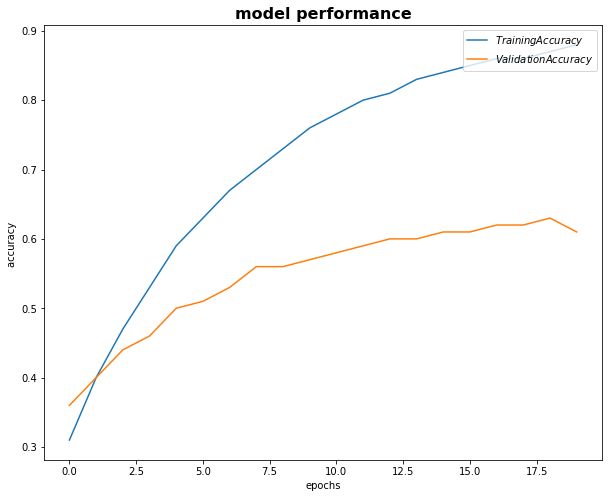

In [32]:
xpoints = np.arange(len(trainLossList))
ypoints4 = trainAccyList
ypoints6 = valAccyList

plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(xpoints, ypoints4, label = "$ Training Accuracy $" )
plt.plot(xpoints, ypoints6, label = "$ Validation Accuracy $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("accuracy ")
plt.show()

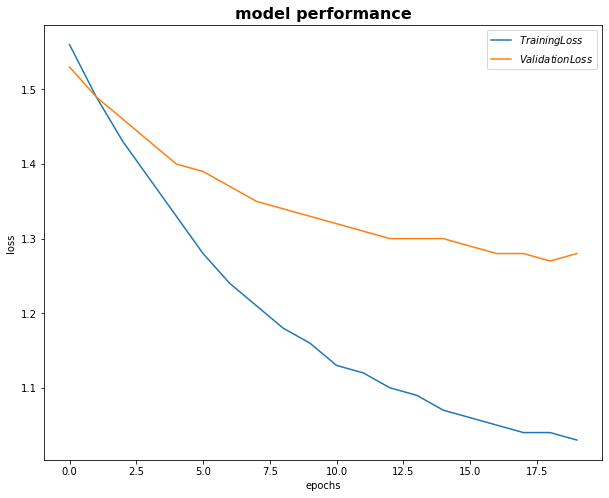

In [33]:
xpoints = np.arange(len(trainLossList))
ypoints0 = trainLossList
ypoints2 = valLossList


plt.rcParams['figure.figsize'] = [10,8]
plt.plot(xpoints, ypoints0 , label = "$ Training Loss $" )
plt.plot(xpoints, ypoints2, label = "$ Validation Loss $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("loss ")
plt.show()

### A utility function to classify any sentence

1.   saved weights are used to classify any input string to predict a label
2.   a cached tokenizer which was saved earlier is used


In [35]:
#load weights and tokenizer

path='./sentence_saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('/content/sentencetokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

categories = {0: "very negative", 1: "negative", 2: "neutral", 3: "positive", 4: "very positive"}
    
def classify_sentence(sentence):
    
    # tokenize the review comment
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [36]:
classify_sentence("The camera twirls ! Oh , look at that ! Wow , a jump cut !")

'negative'

## Testing the model on 10 random review comments from the validation set to predict the label

In [37]:
import random 

from IPython.display import display, Markdown

TESTSAMPLE = 10

validindex = np.arange (len(valid))


randindex = random.choices(validindex , k=10)
  
for i in range(TESTSAMPLE)  :

  out = vars(valid.examples[randindex[i]])
  
  true_label = categories[out['label']]
  in_sentence = ' '.join(out['sentence'])
  pred_label = classify_sentence(in_sentence)

  strTruelabel = 'True label: ' + str(true_label)
  strPredlabel = 'Predicted label: ' +  str(pred_label)
  strSentence =  'Input Sentence: ' + in_sentence
  lineSeparator = '---------------------------------'
  display(Markdown('<strong>{}</strong><br><br><strong>{}</strong><br><br>{}<br><br><strong>{}</strong><br><br>'.format(strTruelabel , strPredlabel , strSentence , lineSeparator)))






<strong>True label: negative</strong><br><br><strong>Predicted label: very negative</strong><br><br>Input Sentence: The movie of n't think much us its characters , its . , or of does protagonist<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: negative</strong><br><br><strong>Predicted label: neutral</strong><br><br>Input Sentence: bake cardboard ask ask ask   call_for call_for call_for   chew .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: neutral</strong><br><br><strong>Predicted label: neutral</strong><br><br>Input Sentence: It 's all pretty tame .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: very positive</strong><br><br><strong>Predicted label: negative</strong><br><br>Input Sentence: The to take the level performances a higher . movie<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: positive</strong><br><br><strong>Predicted label: negative</strong><br><br>Input Sentence: The powerful success of Read My Lips with such provocative why - material , after only three films , director\/co in writer Jacques Audiard , though little known in this country , belongs shows the very top rank of French filmmakers .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: very positive</strong><br><br><strong>Predicted label: positive</strong><br><br>Input Sentence: Children will like its fantasy and adventures , and adults should appreciate their humor .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: positive</strong><br><br><strong>Predicted label: negative</strong><br><br>Input Sentence: If like , guts and crazy beasts stalking with though you will enjoy this monster .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: negative</strong><br><br><strong>Predicted label: very negative</strong><br><br>Input Sentence: Entertains not so much because of its music or comic antics , but through the perverse pleasure of watching Disney scrape the bottom of its own cracker barrel .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: negative</strong><br><br><strong>Predicted label: very negative</strong><br><br>Input Sentence: I 'd be hard pressed to think of a film more cloyingly sappy than Evelyn this year .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: very positive</strong><br><br><strong>Predicted label: very positive</strong><br><br>Input Sentence: The case is a convincing and give anyone with conscience reason to pause .<br><br><strong>---------------------------------</strong><br><br>

# The model could 2 labels correctly out of 10 from the validation dataset

In [ ]:
diagnosticDict = {}

diagnosticDict['num_hidden_nodes'] = num_hidden_nodes
diagnosticDict['num_layers'] = num_layers
diagnosticDict['dropout'] = dropout
diagnosticDict['trainLossList'] = trainLossList
diagnosticDict['valLossList']= valLossList
diagnosticDict['trainAccyList'] = trainAccyList
diagnosticDict['valAccyList'] = valAccyList

#diagnosticDict

In [39]:
import json

out_file = open("lstmdiagnostic.json", "a")
  
json.dump(diagnosticDict, out_file, indent = 6)
  
out_file.close()

In [4]:
with open('./alllstmdiagnostic.json') as f:
  data = json.load(f)
  #print(data)


## Diagnostics

The model was run 3 times with different dropout values , a plot of the model performance across these 3 runs is shown below.


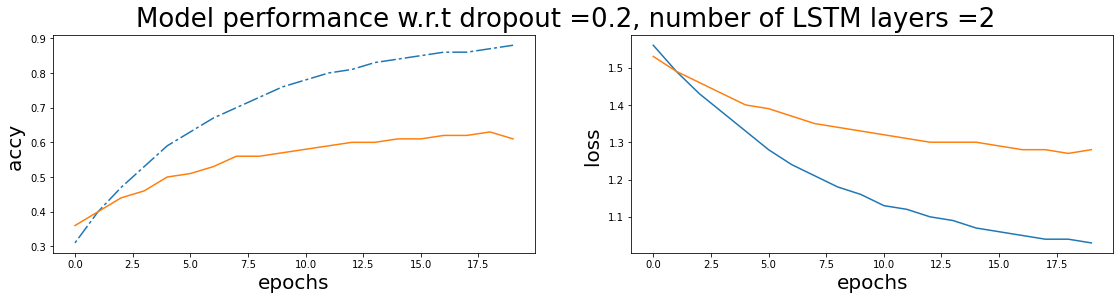

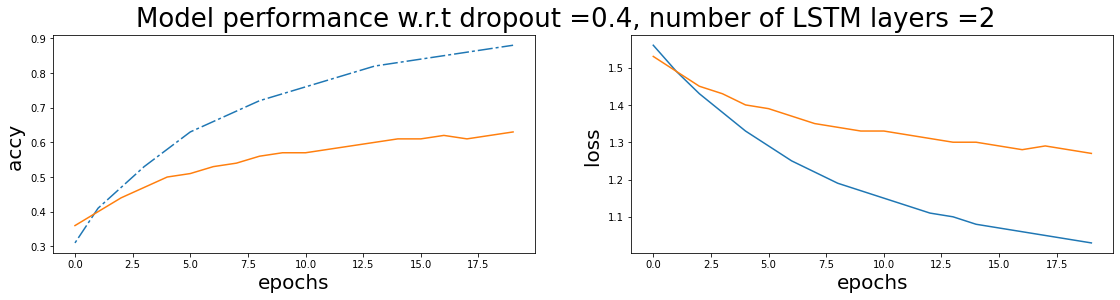

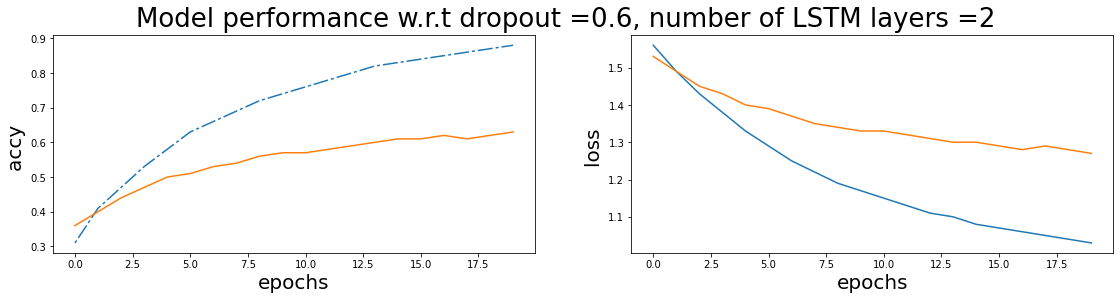

In [14]:
def plotmodelperformance(data):

  for i in range(len(data)):

    my1 = data[i]['trainAccyList']
    my2 = data[i]['valAccyList']
    my3 = data[i]['trainLossList']
    my4 = data[i]['valLossList']
    mx = np.arange(len(my1))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.suptitle('Model performance w.r.t dropout ='+str(data[i]['dropout']) + ', number of LSTM layers =' + str(data[i]['num_layers']), fontsize=26)
    fig.set_figwidth(19)
    #fig.tight_layout(pad = 2.0)

    line1, = ax1.plot(mx, my1, label='trng accy')
    line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

    # Using plot(..., dashes=...) to set the dashing when creating a line
    line2, = ax1.plot(mx, my2 , label='val accy')

    line3, = ax2.plot(mx, my3, label='trng loss')
    line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

    # Using plot(..., dashes=...) to set the dashing when creating a line
    line4, = ax2.plot(mx, my4 , label='val loss')

    #ax1.title("model performance", fontsize=16, fontweight='bold')
    ax1.set_xlabel("epochs" , fontsize=20)
    ax1.set_ylabel("accy " , fontsize=20)
    ax2.set_xlabel("epochs" , fontsize=20)
    ax2.set_ylabel("loss " , fontsize=20)
    #ax.legend()
    plt.show()

plotmodelperformance(data)

# Summary

1.   Training accuracy is above 85% after 20 epochs
2.   Validation accuracy is above 60% after 20 epochs
1.   Training loss is around 1.03 after 20 epochs
2.   Validation loss is around 1.3 after 20 epochs

Dropout did not show any significant difference in model performance , will try out other hyper parameter tuning to improve model performance.

